In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Data Preprocess

In [2]:
train = pd.read_csv("train.csv",dtype = {'VisitNumber': str, 'Upc': str, 'FinelineNumber':str, 'TripType':"category" , 'Weekday':"category"})
test = pd.read_csv("test.csv",dtype = {'VisitNumber': str, 'Upc': str, 'FinelineNumber':str, 'TripType':"category" , 'Weekday':"category"})

In [3]:
dat = pd.concat([train,test])#1300700 rows × 7 columns
dat.reset_index(inplace=True,drop=True)

In [4]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300700 entries, 0 to 1300699
Data columns (total 7 columns):
DepartmentDescription    1298011 non-null object
FinelineNumber           1292585 non-null object
ScanCount                1300700 non-null int64
TripType                 647054 non-null object
Upc                      1292585 non-null object
VisitNumber              1300700 non-null object
Weekday                  1300700 non-null category
dtypes: category(1), int64(1), object(5)
memory usage: 60.8+ MB


In [5]:
dat.drop(['TripType', 'Upc'], axis = 1,inplace = True)

### Missing value

In [6]:
dat.isnull().sum()

DepartmentDescription    2689
FinelineNumber           8115
ScanCount                   0
VisitNumber                 0
Weekday                     0
dtype: int64

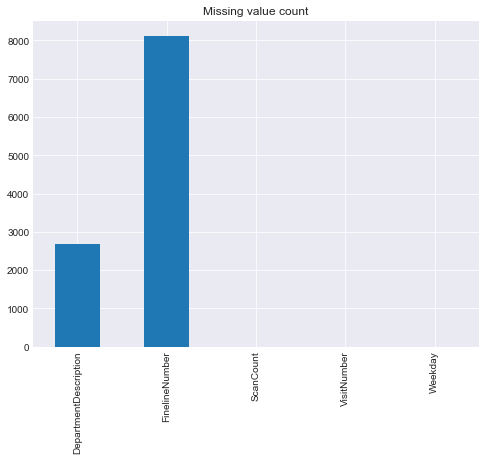

In [7]:
plt.figure(figsize=(8,6))
sns.set_style("darkgrid")
dat.isnull().sum().plot.bar()
plt.title("Missing value count")
plt.show()

In [8]:
#Deal with missing value in Dept with replacement of "dept_other"
dept_missing_index = list(dat[dat['DepartmentDescription'].isnull()].index)
for i in dept_missing_index:
    dat["DepartmentDescription"].iloc[i] = "dept_other"

/Users/michellehsu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
#Deal with missing value in FinelineNumber with replacement of "fn_other"
fn_missing_index = list(dat[dat['FinelineNumber'].isnull()].index)
for i in fn_missing_index:
    dat['FinelineNumber'].iloc[i] = "fn_other"

/Users/michellehsu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
dat.head() #1300700 rows × 5 columns

,DepartmentDescription,FinelineNumber,ScanCount,VisitNumber,Weekday
0,FINANCIAL SERVICES,1000,-1,5,Friday
1,SHOES,8931,1,7,Friday
2,PERSONAL CARE,4504,1,7,Friday
3,PAINT AND ACCESSORIES,3565,2,8,Friday
4,PAINT AND ACCESSORIES,1017,2,8,Friday


### Feature Engineering

#### 1. Spread the FinelineNumber as feature

In [11]:
dat['FinelineNumber_copy'] = dat['FinelineNumber']

In [12]:
group_visit_fineline = dat.groupby(['VisitNumber','FinelineNumber'],as_index=False).agg({'FinelineNumber_copy':'count'})

In [13]:
dictVector = []
visitnum = group_visit_fineline['VisitNumber'][1]
visitdict = {}
for i in range(len(group_visit_fineline)):
    if(group_visit_fineline['VisitNumber'][i] == visitnum):
        visitdict[group_visit_fineline['FinelineNumber'][i]] = group_visit_fineline['FinelineNumber_copy'][i]
    else:
        dictVector.append(visitdict)
        visitdict = {}
        visitdict[group_visit_fineline['FinelineNumber'][i]] = group_visit_fineline['FinelineNumber_copy'][i]
        visitnum = group_visit_fineline['VisitNumber'][i]
# Append the last one
dictVector.append(visitdict)

In [14]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)

In [15]:
X = v.fit_transform(dictVector)

#### 2. Spread the Weekday as feature

In [16]:
day = pd.get_dummies(dat[["VisitNumber", "Weekday"]], columns = ["Weekday"])
day = day.drop_duplicates()

# Find unique VisitNumber
uids = group_visit_fineline['VisitNumber'].unique()

# Keep VisitNumber in uids
day = day[day['VisitNumber'].isin(uids)]

In [17]:
day.sort_values(['VisitNumber'], inplace=True)

In [18]:
new_X = np.concatenate((X, day), axis=1) #(191348, 5362)

#### 3. Spread the DepartmentDescription as feature

In [20]:
dept = dat.groupby(['VisitNumber','DepartmentDescription']).agg({'DepartmentDescription':'count'})

In [21]:
dept = dept.unstack()

In [22]:
dept = dept['DepartmentDescription']

In [23]:
dept.fillna(0, inplace= True)

In [24]:
dp = []
for i in uids:
    dp.append(list(dept.loc[i]))

In [25]:
department = np.array(dp) #(191348, 69)
department[department > 0] = 1

In [26]:
final = np.concatenate((new_X, department), axis=1) #(191348, 5431)

#### Randomly subseting 10000 samples to work through the pipeline

In [28]:
subset = []
for i in np.random.randint(len(final), size = 10000):
    subset.append(final[i])
subset = np.array(subset)

## Dimension Reduction

### PCA

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [30]:
scaler = StandardScaler()
subset_normalized = scaler.fit_transform(subset) 

/Users/michellehsu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [31]:
pca = PCA(1)
pca.fit(subset_normalized)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [32]:
pca.explained_variance_ratio_ 

array([ 0.00367794])

### t-SNE 

In [33]:
from sklearn.manifold import TSNE

In [34]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40) 
tsne_2d = tsne.fit_transform(subset_normalized)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 3.942s...
[t-SNE] Computed neighbors for 10000 samples in 829.332s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 6.481163
[t-SNE] KL divergence after 250 iterations with early exaggeration: 111.156258
[t-SNE] Error after 1000 iterations: 2.557328


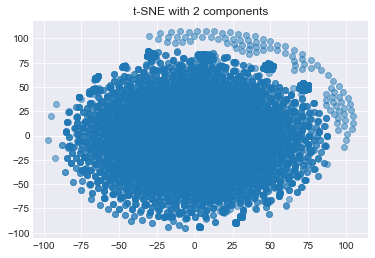

In [39]:
plt.scatter(tsne_2d[:, 0], tsne_2d[:, 1], alpha = 0.5)
plt.title("t-SNE with 2 components")
plt.show()

## Clustering

### GaussianMixture

In [40]:
from sklearn.mixture import GaussianMixture

In [108]:
gmm = GaussianMixture(n_components= 5, n_init= 200)
gmm.fit(tsne_2d)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=200, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [109]:
gmm_cluster_assignments = gmm.predict(tsne_2d)

In [111]:
gmm_cluster_assignments.shape #(10000,)
#gmm_cluster_assignments = gmm_cluster_assignments.reshape((10000, 1))
gmm_cluster_assignments

array([1, 0, 2, ..., 2, 4, 1])

In [99]:
# Append assignment into original data set
#labeled = np.concatenate((subset, gmm_cluster_assignments), axis=1) #(10000, 5432)

## Classification

### Model 1: Random Forest

In [112]:
y = gmm_cluster_assignments
X = subset

In [113]:
# Split data into train and test
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [115]:
# Preparation for tuning the parameters of random forest
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(10, 110, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 10)]
max_depth.append(None)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=1, n_jobs = -1)
# Fit train data to random forest
rf_random.fit(X_train, y_train)
# Predict test data 
pred_rf = rf_random.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.4min finished


In [116]:
rf_random.best_params_

{'max_depth': None, 'n_estimators': 21}

In [117]:
# Evaluate the random forest model 
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm_rf = confusion_matrix(y_test, pred_rf)
#Calculate test error
1-(sum(cm_rf.diagonal())/cm_rf.sum())

0.44450000000000001

In [147]:
rf_cv = RandomForestClassifier(n_estimators= 21)
rf_cv.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=21, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [150]:
importances = rf_cv.feature_importances_
indices = np.argsort(importances)

### Model 2: Adaboost

In [106]:
from sklearn.ensemble import AdaBoostClassifier

In [143]:
# Fit train data to Adaboost
ab = AdaBoostClassifier(learning_rate=1, n_estimators= 200)
ab.fit(X_train, y_train)
# Predict test data 
pred_ab = ab.predict(X_test)

In [144]:
# Evaluate the Adaboost model
cm_ab = confusion_matrix(y_test, pred_ab)
#Calculate test error
1-(sum(cm_ab.diagonal())/cm_ab.sum())

0.48750000000000004

### Model 3: Support Vector Machines

In [128]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [152]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.01, 0.1, 1, 10]
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(svm.SVC(decision_function_shape='ovo', kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [153]:
svc_param_selection(X_train, y_train, 3)

{'C': 0.01}

In [156]:
#Multi-class classification
sv = svm.SVC(C=0.01, decision_function_shape='ovr',kernel='rbf') 
sv.fit(X_train, y_train) 
pred_sv = sv.predict(X_test)

In [157]:
# Evaluate the SVM model
cm_sv = confusion_matrix(y_test, pred_sv)
#Calculate test error
1-(sum(cm_sv.diagonal())/cm_sv.sum())

0.6895